In [1]:
import os
os.chdir('../') 

# Confirm change
print("New working directory:", os.getcwd())

New working directory: /Users/nikhil/Documents/Assignment/StockPredicition


In [2]:
import pandas as pd

data = pd.read_csv('data/AAPL_final_dataset.csv')

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [4]:
# Load model
import joblib
model = joblib.load('models/AAPL_lightgbm_2.pkl')
model

LGBMClassifier(colsample_bytree=0.8728344927965982,
               learning_rate=0.046821189651685656, max_depth=10,
               min_child_samples=9, n_estimators=422, num_leaves=109,
               random_state=42, reg_alpha=0.5183175869808992,
               reg_lambda=0.3217712023285798, subsample=0.8373281229129824,
               verbose=-1)

In [5]:
df = data.dropna().reset_index(drop=True)
X = df.drop(columns=["Date", "Open", "High", "Low", "Close", "Volume", "target",'sentiment_label','sentiment_score'])
y = df['target']

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Keep shuffle=False for time-series
)

X_train,X_val,y_train,y_val =train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False  # Keep shuffle=False for time-series
)

In [7]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    print(f" Dataset Shapes:")
    print(f"Train: {X_train.shape}, Labels: {y_train.shape}")
    print(f"Validation: {X_val.shape}, Labels: {y_val.shape}")
    print(f"Test: {X_test.shape}, Labels: {y_test.shape}")

    print(f"\n Training {name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Accuracy and Classification Reports
    print(f"\n {name} Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print("📄 Train Classification Report:")
    print(classification_report(y_train, y_train_pred))

    print(f"\n {name} Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
    print("📄 Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    print(f"\n {name} Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print("📄 Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # ROC Curves for Train, Val, and Test
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_val_prob = model.predict_proba(X_val)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

        auc_train = roc_auc_score(y_train, y_train_prob)
        auc_val = roc_auc_score(y_val, y_val_prob)
        auc_test = roc_auc_score(y_test, y_test_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {auc_train:.2f})')
        plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.2f})')
        plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'{name} ROC Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid()
        plt.tight_layout()
        plt.show()
    else:
        print(" ROC Curve not available: model does not support probability predictions.")

 Dataset Shapes:
Train: (140, 32), Labels: (140,)
Validation: (36, 32), Labels: (36,)
Test: (44, 32), Labels: (44,)

 Training lightgbm...

 lightgbm Train Accuracy: 1.0000
📄 Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        87

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140


 lightgbm Validation Accuracy: 0.6111
📄 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.39      0.50        18
           1       0.58      0.83      0.68        18

    accuracy                           0.61        36
   macro avg       0.64      0.61      0.59        36
weighted avg       0.64      0.61      0.59        36


 lightgbm Test Accuracy: 0.5455
📄 Test Classification Report:
    

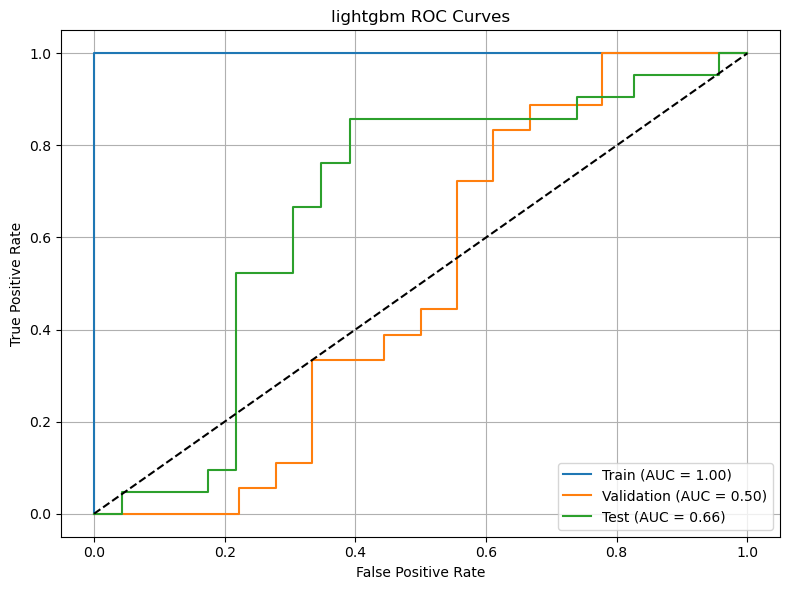

In [8]:
evaluate_model("lightgbm", model, X_train, y_train, X_val, y_val, X_test, y_test)

                Feature  Importance
1            news_count         243
9          lag_3_return         171
10  cumulative_return_3         152
4            lag_1_high         151
19           volatility         140
27  rolling_sentiment_3         116
0        positive_ratio         110
23        volume_change         109
6          lag_1_volume         104
16                  RSI          97
26   sentiment_momentum          91
8          lag_2_return          86
7          lag_1_return          67
25         lag_2_volume          65
17          bollinger_h          60
21  close_to_open_ratio          59
15                 MACD          53
24         volume_SMA_5          50
18          bollinger_l          42
5             lag_1_low          42
28          day_of_week          37
12               SMA_10          36
2           lag_1_close          32
22    high_to_low_ratio          30
3            lag_1_open          28
11                SMA_5          21
20        rolling_std_5     

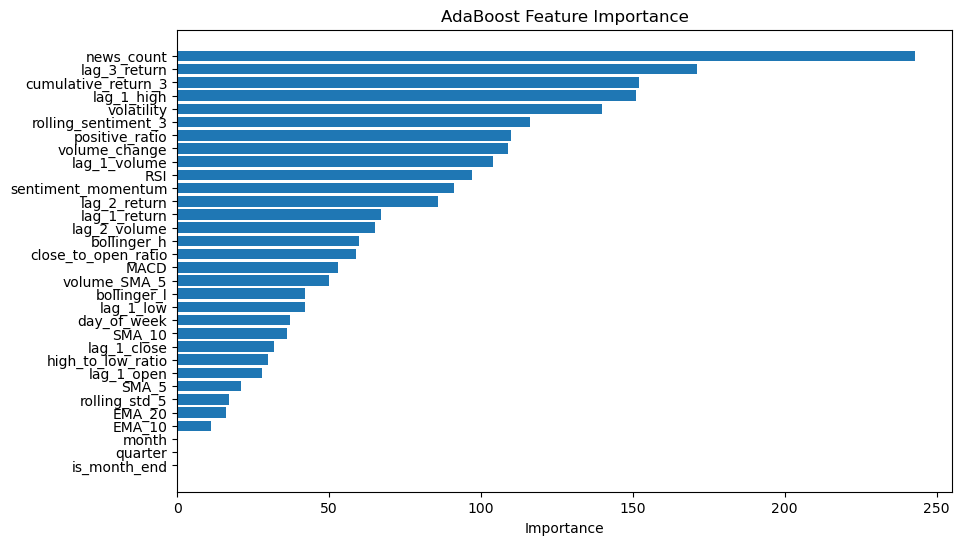

In [9]:
importances = model.feature_importances_
feature_names = X_train.columns  # Or list of feature names if not a DataFrame

# Create a DataFrame for sorting and plotting
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Print
print(feat_imp_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"])
plt.xlabel("Importance")
plt.title("AdaBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

In [10]:
top_10_features = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)['Feature'].tolist()
X_filtered = X[top_10_features]

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_filtered, y, test_size=0.2,  shuffle=False  # Keep shuffle=False for time-series
)

X_train,X_val,y_train,y_val =train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False  # Keep shuffle=False for time-series
)

 Dataset Shapes:
Train: (140, 15), Labels: (140,)
Validation: (36, 15), Labels: (36,)
Test: (44, 15), Labels: (44,)

 Training Tuned_LGBM...

 Tuned_LGBM Train Accuracy: 1.0000
📄 Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        87

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140


 Tuned_LGBM Validation Accuracy: 0.6667
📄 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.39      0.54        18
           1       0.61      0.94      0.74        18

    accuracy                           0.67        36
   macro avg       0.74      0.67      0.64        36
weighted avg       0.74      0.67      0.64        36


 Tuned_LGBM Test Accuracy: 0.6136
📄 Test Classification Repo

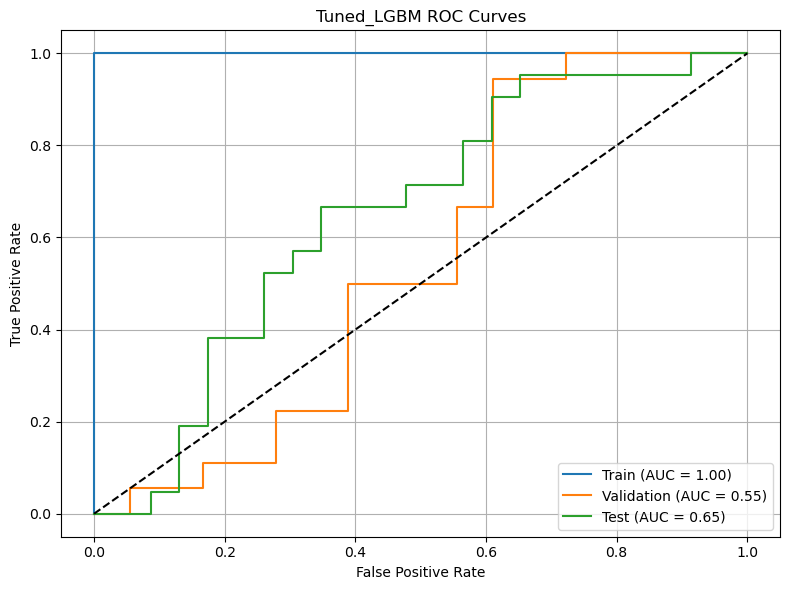

In [12]:
evaluate_model("Tuned_LGBM", model, X_train, y_train, X_val, y_val, X_test, y_test)